# 1. Introduction  
**Human Expression Computer Vision Project**  

**Group Name:** FTDS - 030 - HCK - Group01

**Team Members:**  
- Ghozy Alfisyahr Reuski  
- Brian Nabiel Raharja  
- Muhammad Al Ghifari  
- Ali Abdurrahman  


**AbuLearn Initiative — Organization Background**

AbuLearn initiative is a nonprofit educational foundation dedicated to improving learning outcomes in digital and remore classrooms

**Background**

In online learning environments, student engagement and attentiveness are often difficult for instructors to monitor effectively compared to traditional classrooms [(Madake et al., 2022)](https://ieeexplore.ieee.org/abstract/document/10014782). The lack of direct physical interaction makes it challenging to identify whether students are actively following the lesson or becoming disengaged.



**Problem Statement**

The goal of this project is to develop a predictive machine learning model that can detect and classify students’ facial expressions during online class meetings. By recognizing emotions such as happiness, sadness, neutrality, or surprise, the system aims to provide insights into students’ attentiveness levels, thereby supporting educators in improving the quality of e-learning experiences.


**Dataset Exploration**

This section will explore objective facts and descriptive statistics.

1. What is the class distribution?
2. How many objects per image?
3. What are the resolution of the images?
4. Duplicates or Corrupted Files

**Problem Statement Exploration**

This section connects the dataset findings to the research goal.

1. Can we group the class to 3 labels?



**Objective**   

The model will classify facial expressions into the following categories:

0 → Anger

1 → Contempt

2 → Disgust

3 → Fear

4 → Happy

5 → Neutral

6 → Sad

7 → Surprise

Since these eight emotions may be too granular for the task of measuring student engagement, we also explore grouping them into three higher-level engagement states:

Very Engaged = (Happy, Surprise) 

Nominally Engaged = (Fear, Disgust, Contempt) 

Not Engaged = (Neutral, Sad, Anger)

By recognizing these emotional states, we can gain insights into how attentive students are in class and potentially improve the learning experience through adaptive teaching strategies (e.g., adding interactive content when students appear bored, or providing clarification when students look confused).


**What is this project for?** 

This project is designed to:  
- Help educators monitor student engagement during online classes.  
- Provide data-driven insights into student attentiveness.  
- Support future research in **computer vision applications for education**.  


---

# 2. Import Libraries

In [ ]:
# ========================
# Standard Library
# ========================
import gc
import glob
import hashlib
import math
import os
import random
import shutil
import time
import json
from collections import Counter
from pathlib import Path

# ========================
# Third-Party Core
# ========================
import numpy as np
import pandas as pd
import torch
import yaml

# ========================
# CV / ML / Viz
# ========================
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from ultralytics import YOLO
from PIL import Image
from tqdm import tqdm

---

# 3. Data Loading

In [2]:
# Make a constant random seed
seed = 42
random.seed(seed)
np.random.seed(seed)

# Paths & settings
raw = Path("raw_data")                              # must contain raw_data/images and raw_data/labels
data_root = Path("sample_data")                     # where the sampled & split dataset will be written
sample = 7000                                       # target number of images
split = {"train": 0.8, "val": 0.1, "test": 0.1}     # must sum to 1.0

# Emotion labels (keep 8 classes for now; we’ll collapse to 3 later after EDA)
class_map = {
    0: "Anger", 1: "Contempt", 2: "Disgust", 3: "Fear",
    4: "Happy", 5: "Neutral", 6: "Sad", 7: "Surprise"}

# Quick validations (fail fast)
assert abs(sum(split.values()) - 1.0) < 1e-9, "split must sum to 1.0"
img_dir = raw / "images"
lbl_dir = raw / "labels"
assert img_dir.exists() and lbl_dir.exists(), "Expect raw_data/images and raw_data/labels to exist."

# Ensure output root exists
data_root.mkdir(parents=True, exist_ok=True)

In [3]:
# Scan & primary class per image
def list_images(img_root: Path):
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp")
    files = []
    for e in exts:
        files.extend(img_root.rglob(e))
    return sorted(files)

def read_label_ids(txt_path: Path):
    ids = []
    with open(txt_path) as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            # YOLO labels: first value = class_id
            ids.append(int(float(parts[0])))
    return ids

def mode_id(ids):
    c = Counter(ids)
    m = max(c.values())
    cands = [k for k, v in c.items() if v == m]
    return min(cands)  # tie-breaker: smallest id

rows = []
for ip in list_images(img_dir):
    ip = Path(ip)
    lp = lbl_dir / f"{ip.stem}.txt"
    if not lp.exists():
        continue
    ids = read_label_ids(lp)
    if not ids:
        continue
    rows.append({
        "file_path": str(ip.resolve()),
        "label_path": str(lp.resolve()),
        "primary_class": mode_id(ids)
    })

images_df = pd.DataFrame(rows)
assert len(images_df) > 0, "No valid image/label pairs found."
print("Total pairs:", len(images_df))
print("Initial class distribution (primary_class):")
print(images_df["primary_class"].value_counts().sort_index())

Total pairs: 17101
Initial class distribution (primary_class):
primary_class
0    2339
1    1996
2    2242
3    2021
4    2154
5    1616
6    1914
7    2819
Name: count, dtype: int64


In [4]:
# Stratified subsample to 7k
target_n = int(sample)
if len(images_df) <= target_n:
    subset_df = images_df.copy()
    print(f"[INFO] total ({len(images_df)}) <= sample ({target_n}) → using all data.")
else:
    sss = StratifiedShuffleSplit(n_splits=1, train_size=target_n, random_state=seed)
    idx_train, _ = next(sss.split(images_df["file_path"], images_df["primary_class"]))
    subset_df = images_df.iloc[idx_train].reset_index(drop=True)

print("Subset size:", len(subset_df))
print("Subset class distribution:")
print(subset_df["primary_class"].value_counts().sort_index())

Subset size: 7000
Subset class distribution:
primary_class
0     957
1     817
2     918
3     827
4     882
5     662
6     783
7    1154
Name: count, dtype: int64


In [5]:
# Stratified train/val/test split ===
train_ratio = float(split.get("train", 0.8))
val_ratio   = float(split.get("val", 0.1))
test_ratio  = float(split.get("test", 0.1))

# train vs temp
sss1 = StratifiedShuffleSplit(n_splits=1, train_size=train_ratio, random_state=seed)
train_idx, temp_idx = next(sss1.split(subset_df["file_path"], subset_df["primary_class"]))
train_part = subset_df.iloc[train_idx].reset_index(drop=True)
temp_part  = subset_df.iloc[temp_idx].reset_index(drop=True)

# val vs test inside temp
rel_val = val_ratio / (val_ratio + test_ratio) if (val_ratio + test_ratio) > 0 else 0.5
sss2 = StratifiedShuffleSplit(n_splits=1, train_size=rel_val, random_state=seed)
val_idx, test_idx = next(sss2.split(temp_part["file_path"], temp_part["primary_class"]))
val_part  = temp_part.iloc[val_idx].reset_index(drop=True)
test_part = temp_part.iloc[test_idx].reset_index(drop=True)

print(f"Sizes (train:{len(train_part)}, val:{len(val_part)}, test:{len(test_part)})\n")
for name, part in [("Train",train_part), ("Val",val_part), ("Test",test_part)]:
    print(f"{name} class distribution:\n", part["primary_class"].value_counts().sort_index(), "\n")

Sizes (train:5600, val:700, test:700)

Train class distribution:
 primary_class
0    765
1    654
2    734
3    662
4    706
5    530
6    626
7    923
Name: count, dtype: int64 

Val class distribution:
 primary_class
0     96
1     81
2     92
3     83
4     88
5     66
6     78
7    116
Name: count, dtype: int64 

Test class distribution:
 primary_class
0     96
1     82
2     92
3     82
4     88
5     66
6     79
7    115
Name: count, dtype: int64 



In [6]:
# Materialize to sample_data
def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

for sp in ["train","val","test"]:
    ensure_dir(data_root / "images" / sp)
    ensure_dir(data_root / "labels" / sp)

def link_or_copy(src: Path, dst: Path):
    try:
        if dst.exists():
            dst.unlink()
        os.link(src, dst)  # space/time saver
    except Exception:
        shutil.copy2(src, dst)

def ship(split_name: str, part: pd.DataFrame):
    img_out = data_root / "images" / split_name
    lbl_out = data_root / "labels" / split_name
    rows = []
    for _, r in part.iterrows():
        ip = Path(r["file_path"])
        lp = Path(r["label_path"])
        dst_img = img_out / ip.name
        dst_lbl = lbl_out / lp.name
        link_or_copy(ip, dst_img)
        link_or_copy(lp, dst_lbl)
        rows.append({
            "split": split_name,
            "image_path": str(dst_img.resolve()),
            "label_path": str(dst_lbl.resolve()),
            "primary_class": int(r["primary_class"])
        })
    return pd.DataFrame(rows)

train_df = ship("train", train_part)
val_df   = ship("val",   val_part)
test_df  = ship("test",  test_part)

print("Materialized to:", data_root.resolve())

Materialized to: C:\Users\Ali\Documents\p2-final-project-ftds-030-hck-group01-abulearn-project\Final Project Group 1 HCK 030\p2-final-project-ftds-030-hck-group01-abulearn-project\sample_data


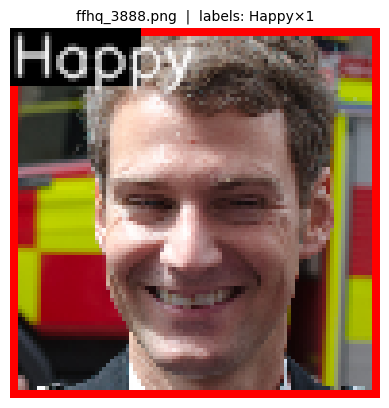

Image file : C:\Users\Ali\Documents\p2-final-project-ftds-030-hck-group01-abulearn-project\Final Project Group 1 HCK 030\p2-final-project-ftds-030-hck-group01-abulearn-project\sample_data\images\train\ffhq_3888.png
Label names: ['Happy']
Counts     : {4: 1}


In [7]:
# Pick 1 random sample from train split
def show_sample_with_labels(df, seed=42, class_map=None):
    # 1) pick one row
    row = df.sample(1, random_state=seed).iloc[0]
    img_path = Path(row["image_path"])
    lbl_path = Path(row["label_path"])
    assert img_path.exists(), f"Image file not found: {img_path}"
    assert lbl_path.exists(), f"Label file not found: {lbl_path}"

    # 2) read image
    img = cv2.imread(str(img_path))
    if img is None:
        raise ValueError(f"cv2.imread returned None for: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # 3) draw boxes + collect class ids
    class_ids = []
    with open(lbl_path) as f:
        for ln in f:
            ln = ln.strip()
            if not ln: 
                continue
            parts = ln.split()
            if len(parts) < 5: 
                continue
            cls, cx, cy, bw, bh = map(float, parts[:5])   # YOLO normalized
            class_ids.append(int(cls))

            x1 = int((cx - bw/2) * w); y1 = int((cy - bh/2) * h)
            x2 = int((cx + bw/2) * w); y2 = int((cy + bh/2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

            # label text (use names if provided)
            name = class_map.get(int(cls), f"id_{int(cls)}") if class_map else str(int(cls))
            tx, ty = x1, max(12, y1 - 6)  # keep text on-canvas
            cv2.rectangle(img, (tx-2, ty-12), (tx-2 + 7*len(name), ty+2), (0,0,0), -1)  # backdrop
            cv2.putText(img, name, (tx, ty), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

    # 4) build label summary
    counts = Counter(class_ids)
    if class_map:
        label_summary = ", ".join([f"{class_map[i]}×{c}" for i, c in counts.items()])
        label_list = [class_map[i] for i in class_ids]
    else:
        label_summary = ", ".join([f"{i}×{c}" for i, c in counts.items()])
        label_list = class_ids

    # 5) show
    plt.imshow(img); plt.axis("off")
    plt.title(f"{img_path.name}  |  labels: {label_summary}", fontsize=10)
    plt.show()

    # also print clean info
    print("Image file :", img_path)
    print("Label names:", label_list)
    print("Counts     :", dict(counts))

# run it
show_sample_with_labels(train_df, seed=seed, class_map=class_map)

# 4. Exploratory Data Analysis


## 4.1 - Dataset Exploration

This section will explore objective facts and descriptive statistics.

1. What is the class distribution?
2. How many objects per image?
3. What are the resolution of the images?
4. Duplicates or Corrupted Files

### 4.1.1 - What is the class distribution?

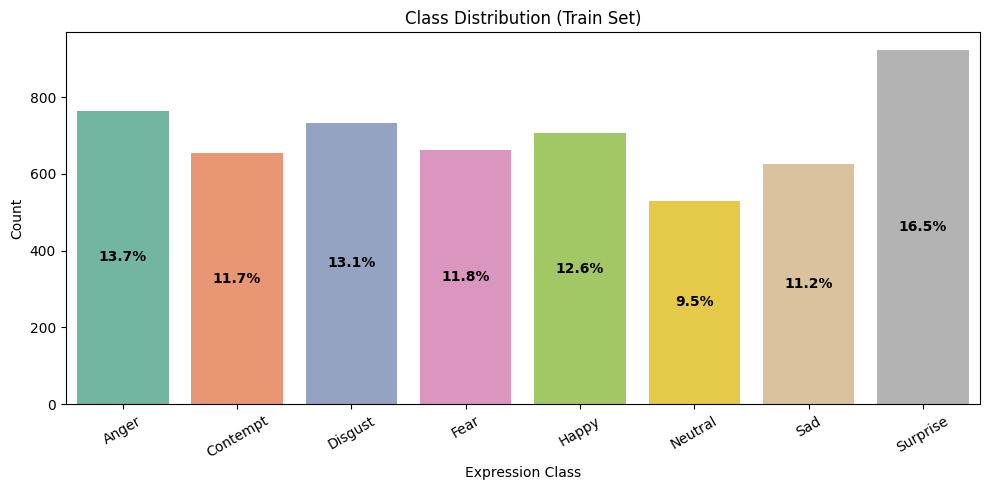

Counts by class:
 class_name
Anger       765
Contempt    654
Disgust     734
Fear        662
Happy       706
Neutral     530
Sad         626
Surprise    923
Name: count, dtype: int64

Percentages by class:
 class_name
Anger       13.66
Contempt    11.68
Disgust     13.11
Fear        11.82
Happy       12.61
Neutral      9.46
Sad         11.18
Surprise    16.48
Name: count, dtype: float64


In [8]:
# collect class ids from YOLO label files in train split
all_ids = []
for p in train_df["label_path"]:
    with open(p, "r", encoding="utf-8") as f:
        for ln in f:
            ln = ln.strip()
            if not ln:
                continue
            parts = ln.split()
            if len(parts) < 5:
                continue
            try:
                cid = int(float(parts[0]))
            except Exception:
                continue
            all_ids.append(cid)

# map to names using your class_map (assumed int->name and already aligned to dataset)
order_ids = sorted(class_map.keys())
order_names = [class_map[i] for i in order_ids]

df_lbl = pd.DataFrame({
    "class_id": all_ids,
    "class_name": [class_map.get(i, f"unknown_{i}") for i in all_ids],
})

# counts & percentages in the intended order
counts = df_lbl["class_name"].value_counts().reindex(order_names, fill_value=0)
percentages = counts / counts.sum() * 100

counts_df = pd.DataFrame({
    "class_name": order_names,
    "count": [int(counts[n]) for n in order_names],
})

# plot
plt.figure(figsize=(10,5))
ax = sns.barplot(
    data=counts_df,
    x="class_name",
    y="count",
    hue="class_name",
    order=order_names,
    palette="Set2",
    legend=False,
)
plt.title("Class Distribution (Train Set)")
plt.xlabel("Expression Class")
plt.ylabel("Count")
plt.xticks(rotation=30)

# annotate percentages on bars
for i, (cnt, pct) in enumerate(zip(counts_df["count"].values, percentages.values)):
    ax.text(i, (cnt/2) if cnt > 0 else 0, f"{pct:.1f}%",
            ha="center", va="center", color="black", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

# raw numbers
print("Counts by class:\n", counts)
print("\nPercentages by class:\n", percentages.round(2))

**Class Balance Analysis (Train Set)**

The dataset shows a **moderate imbalance** across facial expression classes:

* **Surprise** has the highest number of samples (**2,819**).
* **Neutral** has the lowest number of samples (**1,616**).
* Other classes (Anger, Disgust, Happy, Fear, Contempt, Sad) range between \~1,900–2,300 samples.

**Potential Issues**

* Models trained on imbalanced datasets may achieve high accuracy by **predicting the dominant class more often**.
* This reduces reliability, especially for underrepresented classes like *Neutral*, which are still important for detecting engagement.
* In practice, this means the model might overlook subtle disengagement cues while overemphasizing *Surprise*.


**Recommended Approach**

The best course of action is to apply **data augmentation techniques** to increase the representation of minority classes. Instead of duplicating samples, augmentation produces **new, varied training examples**.

**Examples of augmentation:**

* **Rotation** (slight tilts left/right)
* **Flipping** (horizontal/vertical)
* **Scaling & Cropping** (zoom in/out, random crops)
* **Brightness & Contrast adjustment**
* **Adding Gaussian noise or blur**

This method, known as **oversampling with augmentation**, helps to:

* Boost representation of minority classes (e.g., *Neutral*).
* Improve model generalization.
* Reduce the risk of overfitting compared to naive duplication.



With these steps, the dataset can be balanced more effectively, ensuring the model does not disproportionately favor the *Surprise* class while underperforming on *Neutral*.


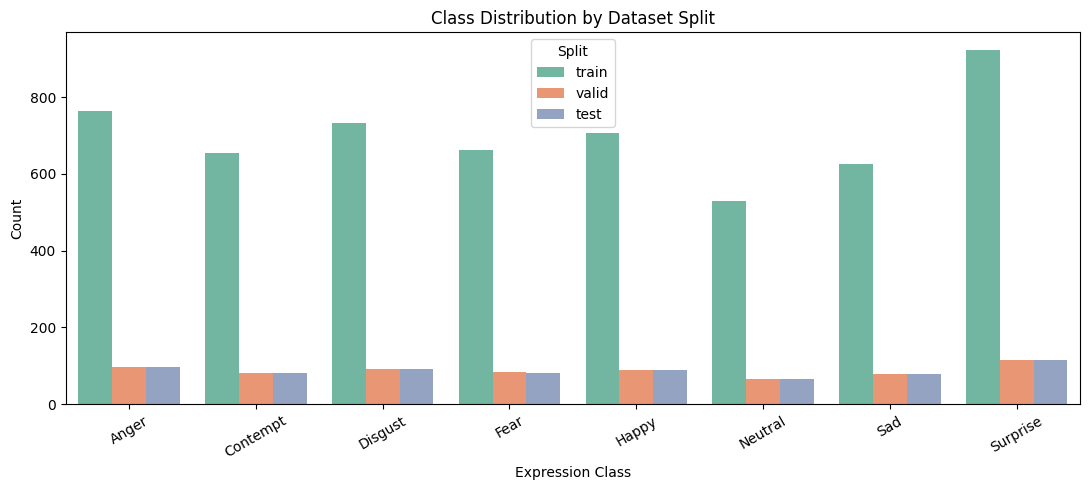

split,train,valid,test
class_name,,,
Anger,765,96,96
Contempt,654,81,82
Disgust,734,92,92
Fear,662,83,82
Happy,706,88,88
Neutral,530,66,66
Sad,626,78,79
Surprise,923,116,115


In [9]:
# EDA: class distribution by split (train/val/test) using existing split dataframes
order_ids   = sorted(class_map.keys())
order_names = [class_map[i] for i in order_ids]

rows = []
for split_name, subset in [("train", train_df), ("val", val_df), ("test", test_df)]:
    cnt = Counter()
    for p in subset["label_path"]:
        with open(p, "r", encoding="utf-8") as f:
            for ln in f:
                ln = ln.strip()
                if not ln: 
                    continue
                parts = ln.split()
                if len(parts) < 5:
                    continue
                try:
                    cid = int(float(parts[0]))
                except Exception:
                    continue
                cnt[cid] += 1
    # materialize counts for all classes so bars stay aligned
    for cid in order_ids:
        rows.append({
            "split": "valid" if split_name == "val" else split_name,  # label as 'valid' if you prefer
            "class_id": cid,
            "class_name": class_map[cid],
            "count": cnt.get(cid, 0),
        })

df_counts = pd.DataFrame(rows)

# plot
plt.figure(figsize=(11,5))
ax = sns.barplot(
    data=df_counts,
    x="class_name",
    y="count",
    hue="split",
    order=order_names,
    hue_order=["train", "valid", "test"],
    palette="Set2")

plt.title("Class Distribution by Dataset Split")
plt.xlabel("Expression Class")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.legend(title="Split")
plt.tight_layout()
plt.show()

# Show counts table for verification
split_order = ["train", "valid", "test"]
tbl = (df_counts
       .pivot_table(index="class_name", columns="split", values="count", aggfunc="sum")
       .reindex(index=order_names, columns=split_order)   # <- urutkan baris & kolom
       .fillna(0).astype(int))

display(tbl)

The dataset splitting strategy is technically sound and well-executed. The use of a stratified split is a best practice that ensures a fair and representative evaluation of the machine learning model across all emotion categories. The relative sizes of the splits are appropriate for model development.

The primary challenge identified in the previous analysis (class imbalance) is a property of the dataset itself, not the splitting method. The splitting method has, in fact, correctly handled this imbalance by reflecting it proportionally across all splits.

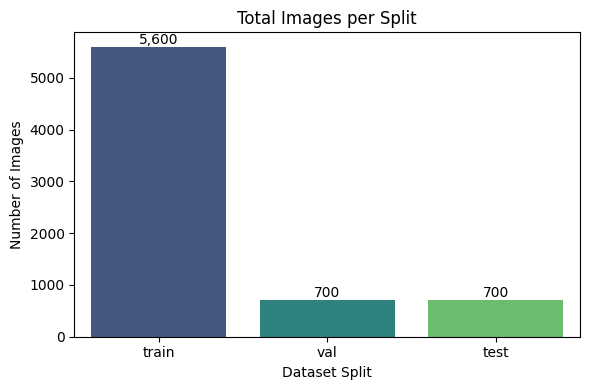

In [10]:
# Total images per split — uses df (one row per image)
img_counts = pd.DataFrame({
    "split": ["train","val","test"],
    "count": [
        train_df["image_path"].nunique(),
        val_df["image_path"].nunique(),
        test_df["image_path"].nunique(),
    ]
})
order = ["train","val","test"]

plt.figure(figsize=(6,4))
ax = sns.barplot(
    data=img_counts, x="split", y="count",
    hue="split", hue_order=order, order=order,
    palette="viridis", dodge=False, legend=False
)
plt.title("Total Images per Split")
plt.xlabel("Dataset Split"); plt.ylabel("Number of Images")

for i, r in img_counts.iterrows():
    ax.text(i, r["count"], f"{int(r['count']):,}", ha="center", va="bottom")

plt.tight_layout(); plt.show()

**1. Key Observations**

**A. Standard and Proportional Split Sizes:**
The distribution of data across the splits follows a very common and sensible machine learning practice, often close to a **70/15/15** or **80/10/10** ratio.
*   **Training Set (`train`):** By far the largest portion. This is optimal as the model needs a substantial amount of data to learn patterns effectively.
*   **Validation Set (`valid`):** Significantly smaller than the training set. Its size is sufficient for its purpose: evaluating the model during training to tune hyperparameters and check for overfitting.
*   **Test Set (`test`):** Roughly the same size as the validation set. This is a good size for a final, unbiased evaluation of the model's performance.

**B. Total Dataset Size:**
Estimating from the bar lengths:
*   The `train` set contains approximately **~14,000** objects.
*   The `valid` and `test` sets each contain approximately **~2,000 - 3,000** objects.
*   This puts the **total dataset size at roughly 18,000 - 20,000 objects**. This is a respectable size for a deep learning project, providing enough data to train a reasonably complex model without an extremely high risk of overfitting, provided techniques like augmentation are used.


**2. Implications**

1.  **Adequate Training Data:** The large size of the training set is a positive sign. It suggests the model has a good foundation of examples to learn from, which is crucial for achieving good performance.
2.  **Reliable Evaluation:** The validation and test sets, while smaller, are not trivial. Having a few thousand samples in each split means that the evaluation metrics (e.g., accuracy, precision, recall) calculated on them will be reasonably stable and reliable, not based on just a handful of examples.
3.  **Potential for Generalization:** This split structure is designed to build a model that generalizes well. The model is trained on one large set (`train`), its configuration is chosen based on a separate, unseen set (`valid`), and its final performance is reported on a third, completely held-out set (`test`). This helps ensure the model learns general patterns rather than memorizing the training data.



**3. Cross-Analysis with the Previous Chart**

This chart complements the previous "Class Distribution by Dataset Split" perfectly:

*   **Chart 1 (Class Distribution)** showed us the ***qualitative*** **distribution** (i.e., *how the **types** of data are split*). It confirmed the splits were stratified and revealed a significant class imbalance.
*   **Chart 2 (Total Objects per Split)** shows us the ***quantitative*** **distribution** (i.e., *how the **volume** of data is split*). It confirms the splits are of an appropriate size.

**Together, they tell a complete story:** The dataset has been split into appropriately sized subsets for training, validation, and testing, **and** the class composition of each subset is consistent and representative of the whole. This is the hallmark of a well-prepared dataset.

The main challenge remains the class imbalance identified in the first chart, but the splitting strategy itself is technically correct and robust.

### 4.1.2 - Objects per image

Average objects per image: 1.0
Max objects in an image: 1
Min objects in an image: 1


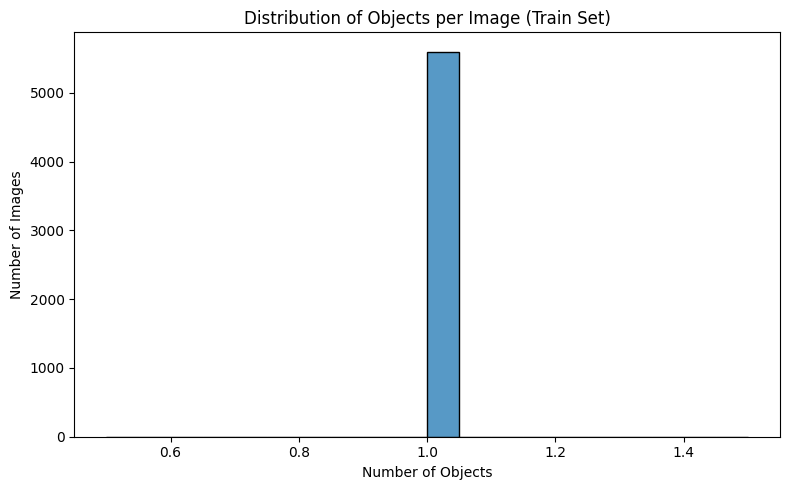

In [11]:
objects_per_image = []
for label_path in train_df["label_path"]:
    with open(label_path, "r", encoding="utf-8") as f:
        n = sum(1 for ln in f if ln.strip())  # 1 baris label = 1 bbox
    objects_per_image.append(n)

# Summary statistics
avg_ = float(np.mean(objects_per_image))
mx_  = int(np.max(objects_per_image))
mn_  = int(np.min(objects_per_image))

print("Average objects per image:", avg_)
print("Max objects in an image:", mx_)
print("Min objects in an image:", mn_)

# Histogram visualization
plt.figure(figsize=(8,5))
sns.histplot(objects_per_image, bins=20, kde=False)
plt.title("Distribution of Objects per Image (Train Set)")
plt.xlabel("Number of Objects")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

All images in the AffectNet YOLO-format dataset were found to contain exactly one object per image, as expected for a facial expression recognition task.

### 4.1.3 - What’s the resolution of the images?

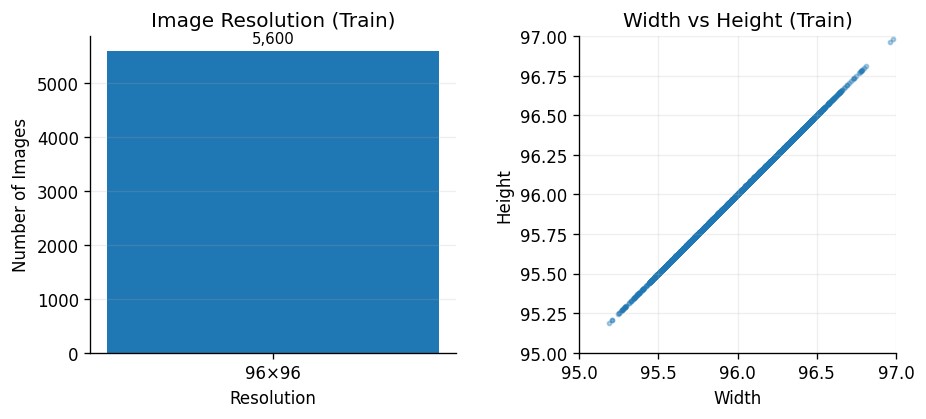

Images read: 5600 | skipped: 0
Average width : 96.0 px
Average height: 96.0 px
Top unique resolutions:


,width,height,count
0,96,96,5600


In [12]:
# Collect image resolutions (train set only)
widths, heights = [], [] # Collect widths & heights
skipped = 0
for p in train_df["image_path"]:
    try:
        with Image.open(p) as im:
            w, h = im.size
        widths.append(w); heights.append(h)
    except Exception:
        skipped += 1

wmin, wmax = min(widths), max(widths)
hmin, hmax = min(heights), max(heights)

# Plots (2 subplots in one figure)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.6), dpi=120)

# (left) resolution distribution
if wmin == wmax and hmin == hmax:
    bars = ax1.bar([f"{wmin}×{hmin}"], [len(widths)], width=0.5)
    ax1.bar_label(bars, labels=[f"{len(widths):,}"], padding=3, fontsize=9)
    ax1.set_xlabel("Resolution"); ax1.set_ylabel("Number of Images")
    ax1.set_title("Image Resolution (Train)")
else:
    bins = np.arange(min(wmin, hmin) - 0.5, max(wmax, hmax) + 1.5, 1)
    ax1.hist(widths,  bins=bins, alpha=0.6, label="Width")
    ax1.hist(heights, bins=bins, alpha=0.6, label="Height")
    ax1.legend(frameon=False)
    ax1.set_xlabel("Pixels"); ax1.set_ylabel("Number of Images")
    ax1.set_title("Image Resolution (Train)")
ax1.grid(axis="y", alpha=0.2)
ax1.spines["top"].set_visible(False); ax1.spines["right"].set_visible(False)

# (right) width vs height scatter
x = np.array(widths, dtype=float); y = np.array(heights, dtype=float)
if wmin == wmax and hmin == hmax:
    jitter = np.random.normal(0, 0.25, size=len(x))  # tiny jitter for visibility
    x += jitter; y += jitter
    ax2.set_xlim(wmin - 1, wmin + 1)
    ax2.set_ylim(hmin - 1, hmin + 1)

ax2.scatter(x, y, s=6, alpha=0.35)
ax2.set_title("Width vs Height (Train)")
ax2.set_xlabel("Width"); ax2.set_ylabel("Height")
ax2.set_aspect("equal", adjustable="box")
ax2.grid(alpha=0.2)
ax2.spines["top"].set_visible(False); ax2.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

# Quick summary printout (robust)
res_counts = (
    pd.DataFrame({"width": widths, "height": heights})
      .value_counts()                         # counts by (width,height)
      .reset_index(name="count")              # columns: width, height, count
      .sort_values("count", ascending=False)
)

print(f"Images read: {len(widths)} | skipped: {skipped}")
print(f"Average width : {np.mean(widths):.1f} px")
print(f"Average height: {np.mean(heights):.1f} px")
print("Top unique resolutions:")
display(res_counts.head(10))

**Image Resolution Analysis (Train Set)**

* **Average width**: 96.0 px
* **Average height**: 96.0 px
* **Unique resolutions found**: {(96, 96)}

**Insights**

* All images in the training set are exactly **96×96 pixels**.
* This indicates that the dataset has already been **cleaned and standardized**.
* No additional resizing is required beyond what the YOLO dataloader already does (letterbox/scale to `imgsz`).

**Implication for Modeling**

* Use **YOLO** end-to-end; no separate “CNN feature extraction” baseline is needed.
* Set imgsz=96 (or 128 if prefer a small upscale).
* Apply train-time augmentations safely; keep mosaic disabled or very low for small images like 96×96.

### 4.1.4 - Corrupted or Duplicates Files

In [13]:
# Check corrupted images
split_dfs = {"train": train_df, "val": val_df, "test": test_df}

corrupted = {sp: [] for sp in split_dfs}
for sp, sdf in split_dfs.items():
    for img_p in sdf["image_path"]:
        try:
            with Image.open(img_p) as im:
                im.verify()
        except Exception as e:
            corrupted[sp].append((str(img_p), str(e)))

for sp in ["train","val","test"]:
    print(f"{sp}: {len(corrupted[sp])} corrupted")

train: 0 corrupted
val: 0 corrupted
test: 0 corrupted


All images in the training set passed the integrity check, with zero corrupted files detected, indicating that the dataset has already been thoroughly cleaned and is ready for preprocessing and modeling without concerns about broken or unreadable samples.

MD5 duplicate groups: 23 | images involved: 50


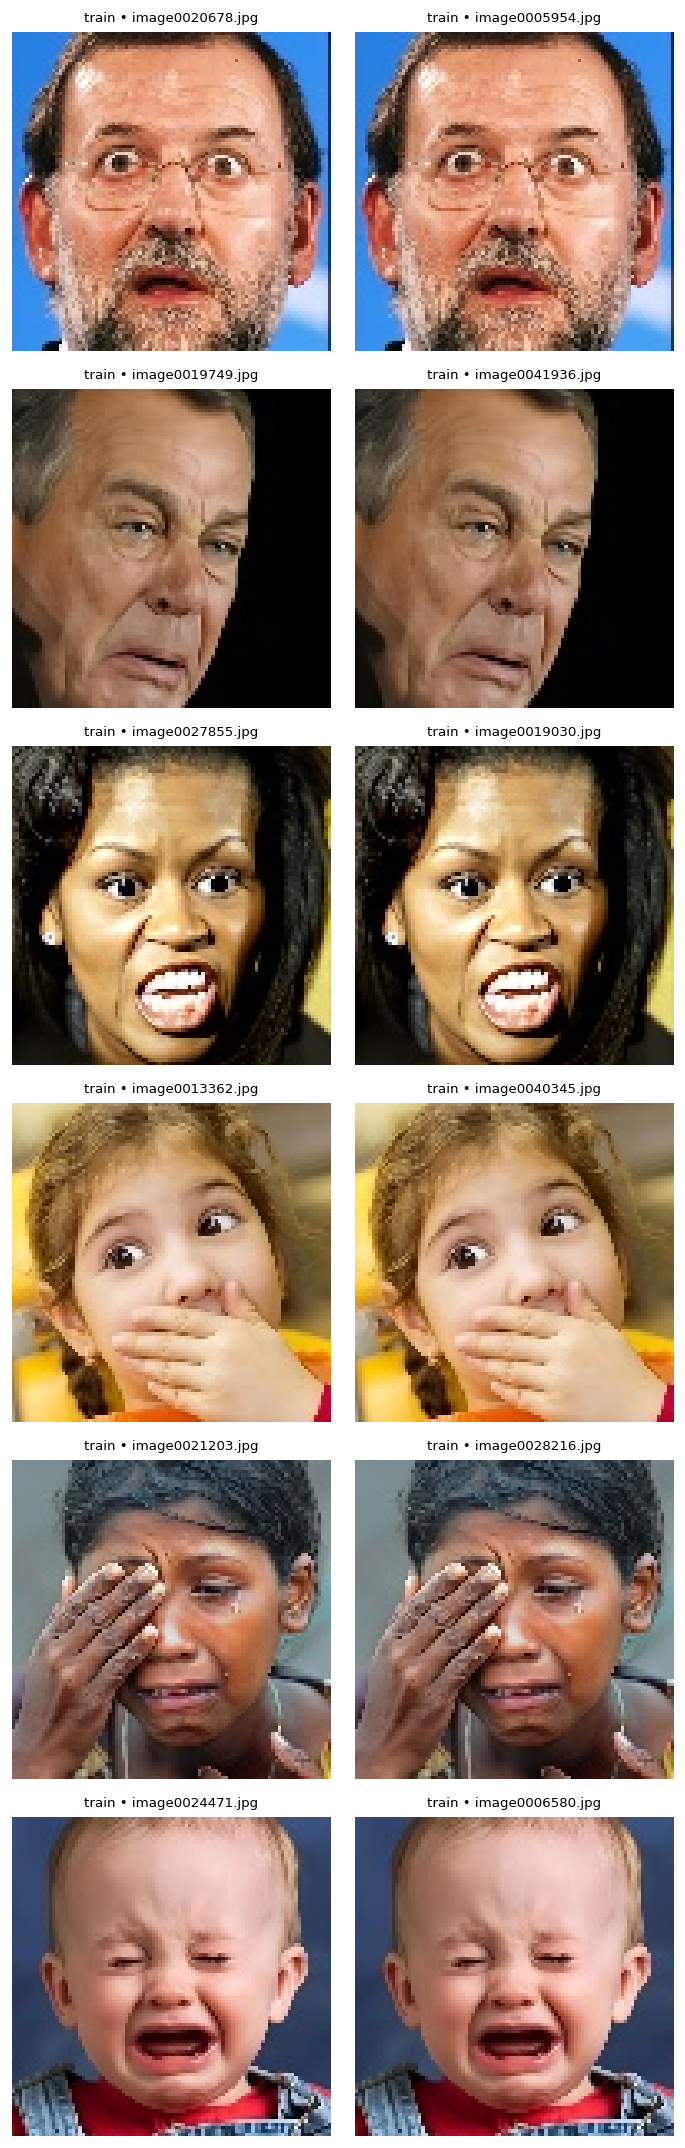

In [14]:
dfs = []
if "train_df" in globals(): dfs.append(train_df.assign(split="train"))
if "val_df"   in globals(): dfs.append(val_df.assign(split="val"))
if "test_df"  in globals(): dfs.append(test_df.assign(split="test"))
all_df = pd.concat(dfs, ignore_index=True)[["split","image_path"]].copy()
all_df["image_path"] = all_df["image_path"].astype(str)

def md5sum(p, chunk_size=2<<20):
    h = hashlib.md5()
    with open(p, "rb") as f:
        for b in iter(lambda: f.read(chunk_size), b""):
            h.update(b)
    return h.hexdigest()

all_df["md5"] = all_df["image_path"].apply(md5sum)
dups = all_df.groupby("md5").filter(lambda g: len(g) > 1)

num_groups = dups["md5"].nunique()
num_files  = len(dups)
print(f"MD5 duplicate groups: {num_groups} | images involved: {num_files}")

# Small gallery (first K groups, up to M images each)
K, M = 6, 2
if num_groups > 0:
    md5_list = dups["md5"].drop_duplicates().head(K).tolist()
    fig, axes = plt.subplots(len(md5_list), M, figsize=(3*M, 3*len(md5_list)), dpi=120)
    if len(md5_list) == 1: axes = np.array([axes])
    for r, h in enumerate(md5_list):
        g = dups[dups["md5"] == h].head(M).reset_index(drop=True)
        for c in range(M):
            ax = axes[r, c] if M > 1 else axes[r, 0]
            ax.axis("off")
            if c < len(g):
                p, sp = g.loc[c, "image_path"], g.loc[c, "split"]
                try:
                    ax.imshow(Image.open(p).convert("RGB"))
                    ax.set_title(f"{sp} • {Path(p).name}", fontsize=8)
                except Exception:
                    ax.text(0.5,0.5,"[cannot open]", ha="center", va="center", fontsize=8)
    plt.tight_layout(); plt.show()
else:
    print("No MD5 duplicates found.")

**Content-duplicate summary (MD5)**

* MD5 duplicate groups: 23

* Images involved: 50 (≈ 0.71% of 7,000)

* Note: we report duplicate groups (by MD5), not “pairs”, because one file can form multiple pairs.

* Anecdotal context: In large Computer Vision datasets, a small fraction of duplicates typically doesn’t hurt training much:

  > “If it's 10,000 unique images, but then some of them occur 2 or 3 times, it won't make a noticeable difference.”
  > [Reddit](https://www.reddit.com/r/MachineLearning/comments/g7gxah/d_would_duplicate_images_in_a_dataset_noticeably/)


**Interpretation & Recommendation**

* The proportion of exact duplicates is small, so the impact on training is expected to be negligible.

* The primary risk is data leakage across splits. We will deduplicate across splits by keeping exactly one copy per MD5 (preference: train > val > test) and removing any copies from validation/test.

* After de-duplication, we will recompute class counts and proceed with modeling to ensure fair evaluation.

* This follows common practice and avoids inflated metrics due to memorization (see e.g., [Barz & Denzler (2020)](https://arxiv.org/abs/1902.00423)).

## 4.2 - Problem Statement Exploration

### 4.2.1 - Can we group the class to 3 labels?


[Sharma et al. (2019)](https://arxiv.org/abs/1909.12913) proposed an engagement detection system that classifies students into three levels (**Very Engaged**, **Nominally Engaged**, and **Not Engaged at All**) using facial emotions, eye tracking, and head movement.

This supports our approach of grouping eight basic emotions into three broader categories:

**Very Engaged** = (Happy, Surprise) 

**Nominally Engaged** = (Fear, Disgust, Contempt) 

**Not Engaged** = (Neutral, Sad, Anger)

By aligning with this framework, we simplify classification, reduce imbalance, and make the results more actionable for e-learning.

Based on the literature review, we can safely group the expressions into engagement classes and visualize what the balance looks like.


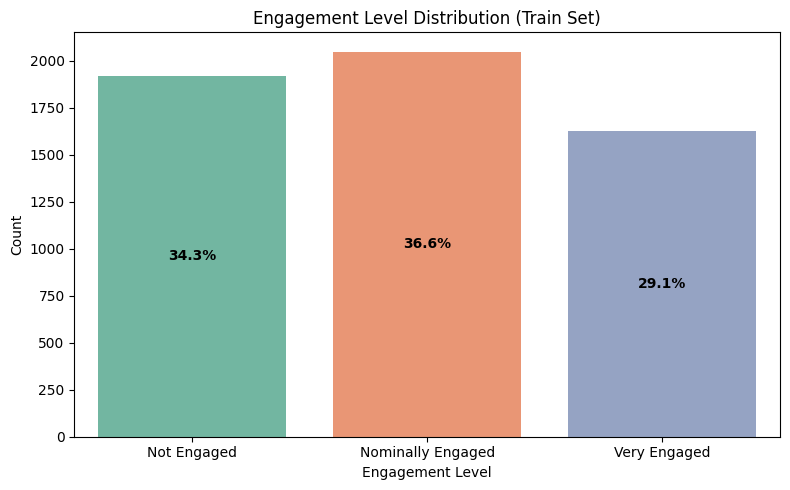

In [15]:
# Engagement mapping 
engagement_map = {
    "Happy": "Very Engaged",
    "Surprise": "Very Engaged",
    "Fear": "Nominally Engaged",
    "Disgust": "Nominally Engaged",
    "Contempt": "Nominally Engaged",
    "Neutral": "Not Engaged",
    "Sad": "Not Engaged",
    "Anger": "Not Engaged"}

label_counts = Counter()
for p in train_df["label_path"]:
    with open(p, "r", encoding="utf-8") as f:
        for ln in f:
            ln = ln.strip()
            if not ln:
                continue
            parts = ln.split()
            if len(parts) < 5:
                continue
            try:
                cid = int(float(parts[0]))   # YOLO: first token is class id
            except Exception:
                continue
            label_counts[cid] += 1

# 3) Convert class id -> class name (use existing class_map), then map to engagement level
rows = []
for cid, cnt in label_counts.items():
    cname = class_map.get(cid, str(cid))           # id -> class name
    eng   = engagement_map.get(cname, "Unknown")   # name -> engagement bucket
    rows.append({"engagement": eng, "count": cnt})

eng_df = pd.DataFrame(rows)

# 4) Aggregate to 3 buckets and keep a fixed bar order
eng_order = ["Not Engaged", "Nominally Engaged", "Very Engaged"]
eng_counts = (
    eng_df.groupby("engagement", as_index=False)["count"].sum()
          .set_index("engagement")
          .reindex(eng_order, fill_value=0)
          .reset_index())

# 5) Percentages for nice labels inside bars
percentages = eng_counts["count"] / eng_counts["count"].sum() * 100

# 6) Plot (train set only)
plt.figure(figsize=(8,5))
ax = sns.barplot(
    data=eng_counts,
    x="engagement", y="count",
    hue="engagement",          # use x as hue to fix seaborn warning and colors
    order=eng_order,
    palette="Set2",
    legend=False)

plt.title("Engagement Level Distribution (Train Set)")
plt.xlabel("Engagement Level"); plt.ylabel("Count")

# put percentage labels inside bars
for i, (c, p) in enumerate(zip(eng_counts["count"].values, percentages.values)):
    ax.text(i, (c/2) if c > 0 else 0, f"{p:.1f}%",
            ha="center", va="center", fontweight="bold")

plt.tight_layout()
plt.show()

**Insights**

The dataset is relatively balanced across engagement levels, but still shows some moderate imbalance.

Nominally Engaged has the largest share (36.6%), while Very Engaged is the lowest (29.1%).

Since the differences are not extreme, training a model directly on these three groups is feasible.

---

**Important Note**

Augmentation should not be done at the engagement level (3 classes), because those categories are derived, and will harm the original dataset.
Instead, augmentation must be applied to the original 8 emotion classes (Anger, Contempt, Disgust, Fear, Happy, Neutral, Sad, Surprise).

---

**Recommendation**

Apply data augmentation (rotation, flipping, brightness adjustment, etc.) to the underrepresented original emotion classes.

Then regroup into engagement levels.

This preserves a more natural balance across the three engagement categories while keeping data realistic.

---

## 4.3 - Conclusion and Recommendations Exploration

**Dataset Problems Identified in EDA**

1. **Class Distribution**

   * Moderate imbalance among the 8 classes (*Surprise* highest, *Neutral* lowest).
   * Risk of biased predictions toward majority classes.

2. **Objects per Image**

   * Exactly **1 object per image**.
   * Confirms the dataset is consistent and specialized for single-face recognition.

3. **Image Resolution**

   * All images are **96×96 pixels**.
   * Dataset is already standardized and does not require resizing.

4. **Duplicates & Corrupted Files**

   * **0 corrupted files**.
   * **126 duplicate pairs** found, but duplicates in vision datasets are generally a **minor issue** unless they appear in validation/test splits (Barz & Denzler, 2020).

---

**Key Insights from Grouping into Engagement Levels**

* Mapping 8 emotions into **3 engagement categories** (Very Engaged, Nominally Engaged, Not Engaged) makes the problem more interpretable and practical.
* Distribution across 3 groups is **relatively balanced** (36.6% Nominally Engaged, 34.3% Not Engaged, 29.1% Very Engaged).
* Augmentation should be done on the **original 8 classes**, not directly on the grouped levels, to maintain semantic validity.

---

**Recommendation for Preprocessing (Next Step)**

1. **MD5 de-duplication across splits (prevent leakage)**

   * Keep exactly one file per MD5 group (priority: **train → val → test**).
   * Remove any remaining copies from **validation/test**.
   * Recompute split/class counts afterward.
   * **Skip if heavy**: keep the MD5 check but skip any image preview/visualization. For 7k sample images, MD5 itself is fast.

2. **Relabel 8 Emotions → 3 Engagement Classes (labels only)**

   * After augmentation, regroup emotions into **3 engagement levels**.
   * This step will reduce imbalance and simplify classification.

3. **Assemble Final YOLO Dataset & YAML (3 classes)**

   * Ensure each image has a corresponding 3-class label file.
   * Create a single YAML with nc: 3, names: [`'Not Engaged','Nominally Engaged','Very Engaged'`], and the absolute paths for train, val, test.

4. **On-the-fly Augmentation (Light, Face-Safe)**

   * Turn off heavy aug for small faces: `mosaic=0`, `mixup=0`.
   * Use mild transforms: degrees=10, translate=0.05, scale=0.10, fliplr=0.5, flipud=0, optional mild HSV jitter.
   * Keep val/test clean (no aug).

5. **Normalization**

   * No offline normalization needed, YOLO normalizes internally.
   * Train with `imgsz=96` (matches data; fastest). If accuracy stalls, try `imgsz=128` as a controlled upgrade.

6. **Cheap Sanity Checks (post-remap)**

   * Print per-split image and engagement counts.
   * Visualize one random sample per split with bbox + engagement text.

7. **Training Setup Tuned**

   * Start with `yolov8n` for quick iterations; move to `-s` only if needed.
   * Runtime: `device=mps/cuda`, `imgsz=96`, `workers=0–1`, `batch 8–16` (use accumulate=2 if tight), `amp=auto` (set amp=False if unstable), `cache=False` on 8-GB RAM; schedule = 5 warm (freeze=10) + 25 fine-tune (patience≈10).
   * Metrics: monitor per-class PR/F1; if one engagement class lags, consider slightly stronger aug or minor class weighting.

---

**Final Note:**
The dataset is clean and standardized (96×96). The main challenge is mild class imbalance, which we address with targeted augmentation. **YOLO** is well-suited here because it performs joint detection + classification efficiently and scales to multi-face classroom scenarios without changing the architecture.


# 5. Preprocessing

In [16]:
# Final 3-class engagement names (fixed order -> ids 0..2)
eng_name = ["Not Engaged", "Nominally Engaged", "Very Engaged"]
eng_name2id = {n:i for i,n in enumerate(eng_name)}

# Map original 8 emotion names -> 3 engagement names
emo2eng_name = {
    "Happy": "Very Engaged",
    "Surprise": "Very Engaged",
    "Fear": "Nominally Engaged",
    "Disgust": "Nominally Engaged",
    "Contempt": "Nominally Engaged",
    "Neutral": "Not Engaged",
    "Sad": "Not Engaged",
    "Anger": "Not Engaged"}

# Build id-to-id mapper: original emotion id -> engagement id (0..2)
emoid2engid = {
    emo_id: eng_name2id[emo2eng_name[class_map[emo_id]]]
    for emo_id in class_map.keys()}

# Output dataset root (3-class)
out_root = data_root / "sample_data_cleaned"
(out_root / "train" / "images").mkdir(parents=True, exist_ok=True)
(out_root / "train" / "labels").mkdir(parents=True, exist_ok=True)
(out_root / "val"   / "images").mkdir(parents=True, exist_ok=True)
(out_root / "val"   / "labels").mkdir(parents=True, exist_ok=True)
(out_root / "test"  / "images").mkdir(parents=True, exist_ok=True)
(out_root / "test"  / "labels").mkdir(parents=True, exist_ok=True)

# Small helpers
def md5sum(fp: Path, buf_size: int = 1 << 20) -> str:
    """Compute md5 hash of a file efficiently (chunked)."""
    h = hashlib.md5()
    with open(fp, "rb") as f:
        while True:
            b = f.read(buf_size)
            if not b:
                break
            h.update(b)
    return h.hexdigest()

def link_or_copy(src: Path, dst: Path) -> None:
    """Prefer symlink to save disk; fallback to copy if not allowed."""
    try:
        if dst.exists():
            dst.unlink()
        os.symlink(src, dst)
    except Exception:
        shutil.copy2(src, dst)

## 5.1 - Cross-split MD5 De-duplication

In [17]:
# Build a single dataframe view with split info and absolute image paths
train_df_ = train_df.assign(split="train")[["image_path", "label_path", "split"]].copy()
val_df_   = val_df.assign(split="val")[["image_path", "label_path", "split"]].copy()
test_df_  = test_df.assign(split="test")[["image_path", "label_path", "split"]].copy()
all_df = pd.concat([train_df_, val_df_, test_df_], ignore_index=True)

# Compute MD5 per image
tqdm.pandas(desc="MD5")
all_df["md5"] = all_df["image_path"].progress_apply(lambda p: md5sum(Path(p)))

# For each md5 group, keep exactly one row with priority: train > val > test
priority = {"train": 0, "val": 1, "test": 2}
all_df["prio"] = all_df["split"].map(priority)

keep_idx = (
    all_df.sort_values(["md5", "prio"])   # lower prio kept
         .groupby("md5", as_index=False)
         .first()
         .index)

all_df["keep"] = False
all_df.loc[keep_idx, "keep"] = True

# Count rows we drop by split (duplicates across splits only)
dropped = all_df.loc[~all_df["keep"]].groupby("split").size().to_dict()
kept    = all_df.loc[ all_df["keep"]].groupby("split").size().to_dict()
print("Kept per split :", kept)
print("Dropped (dups) :", dropped)

# Final filtered frames to use downstream
train_keep = all_df[(all_df["split"]=="train") & (all_df["keep"])].copy()
val_keep   = all_df[(all_df["split"]=="val")   & (all_df["keep"])].copy()
test_keep  = all_df[(all_df["split"]=="test")  & (all_df["keep"])].copy()

MD5: 100%|██████████| 7000/7000 [00:04<00:00, 1645.09it/s]

Kept per split : {'test': 673, 'train': 5600, 'val': 700}
Dropped (dups) : {'test': 27}


## 5.2 - Label Remapping (Emotions to Engagement Classes)

In [18]:
# Show engangement id and name
id2name = {i: n for i, n in enumerate(eng_name)}
import pandas as pd
display(pd.DataFrame.from_dict(id2name, orient="index", columns=["class_name"]).rename_axis("class_id"))

,class_name
class_id,
0,Not Engaged
1,Nominally Engaged
2,Very Engaged


In [19]:
# Remap labels (8->3) and assemble the 3-class YOLO dataset
def remap_label_file(src_lbl: Path, dst_lbl: Path, id_map: dict[int,int]) -> int:
    """
    Read YOLO .txt, map emotion id -> engagement id.
    Returns number of objects written.
    """
    lines_out = []
    if src_lbl.exists():
        with open(src_lbl, "r", encoding="utf-8") as f:
            for ln in f:
                ln = ln.strip()
                if not ln:
                    continue
                parts = ln.split()
                if len(parts) < 5:
                    continue
                try:
                    emo_id = int(float(parts[0]))
                except Exception:
                    continue
                eng_id = id_map.get(emo_id, None)
                if eng_id is None:
                    continue
                parts[0] = str(eng_id)
                lines_out.append(" ".join(parts))
    # Write (even if empty -> valid 'no object' file if needed)
    with open(dst_lbl, "w", encoding="utf-8") as f:
        f.write("\n".join(lines_out))
    return len(lines_out)

def build_split(split_name: str, df_keep: pd.DataFrame) -> dict:
    """Link/Copy images and write remapped labels for one split."""
    out_img_dir = out_root / split_name / "images"
    out_lbl_dir = out_root / split_name / "labels"
    counts = {0:0, 1:0, 2:0}
    n_files = 0

    for _, row in tqdm(df_keep.iterrows(), total=len(df_keep), desc=f"Build {split_name}"):
        src_img = Path(row["image_path"])
        src_lbl = Path(row["label_path"])

        dst_img = out_img_dir / src_img.name
        dst_lbl = out_lbl_dir / (src_img.stem + ".txt")

        link_or_copy(src_img, dst_img)
        n = remap_label_file(src_lbl, dst_lbl, emoid2engid)

        # Count per-engagement object quickly (by scanning freshly written label)
        if dst_lbl.exists():
            with open(dst_lbl, "r", encoding="utf-8") as f:
                for ln in f:
                    ln = ln.strip()
                    if not ln: 
                        continue
                    cid = int(ln.split()[0])
                    counts[cid] = counts.get(cid,0) + 1

        n_files += 1

    return {"files": n_files, "obj_per_class": counts}

stats_train = build_split("train", train_keep)
stats_val   = build_split("val",   val_keep)
stats_test  = build_split("test",  test_keep)

print("Train:", stats_train)
print("Val  :", stats_val)
print("Test :", stats_test)

Build test: 100%|██████████| 673/673 [00:01<00:00, 465.61it/s]

Train: {'files': 5600, 'obj_per_class': {0: 1921, 1: 2050, 2: 1629}}
Val  : {'files': 700, 'obj_per_class': {0: 240, 1: 256, 2: 204}}
Test : {'files': 673, 'obj_per_class': {0: 234, 1: 244, 2: 195}}


## 5.3 - Quick Sanity Checks (Counts + Preview)

train objects: {'Not Engaged': 1921, 'Nominally Engaged': 2050, 'Very Engaged': 1629}
val objects: {'Not Engaged': 240, 'Nominally Engaged': 256, 'Very Engaged': 204}
test objects: {'Not Engaged': 234, 'Nominally Engaged': 244, 'Very Engaged': 195}

One Preview of Train Set:


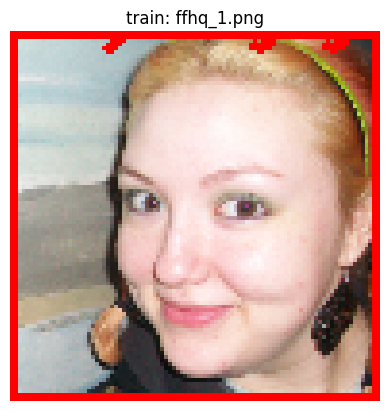

In [20]:
# Quick sanity checks
def count_eng_objects(lbl_dir: Path) -> Counter:
    c = Counter()
    for p in lbl_dir.glob("*.txt"):
        with open(p, "r", encoding="utf-8") as f:
            for ln in f:
                ln = ln.strip()
                if not ln: 
                    continue
                cid = int(ln.split()[0])
                c[cid]+=1
    return c

def show_one(split: str):
    img_dir = out_root / split / "images"
    lbl_dir = out_root / split / "labels"
    img_path = next(img_dir.glob("*.*"))
    lbl_path = lbl_dir / (img_path.stem + ".txt")

    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    if lbl_path.exists():
        with open(lbl_path, "r", encoding="utf-8") as f:
            for ln in f:
                parts = ln.strip().split()
                if len(parts)<5: 
                    continue
                cid, cx, cy, bw, bh = map(float, parts[:5])
                x1 = int((cx - bw/2) * w); y1 = int((cy - bh/2) * h)
                x2 = int((cx + bw/2) * w); y2 = int((cy + bh/2) * h)
                cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
                cv2.putText(img, eng_name[int(cid)], (x1, max(0,y1-5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
    plt.imshow(img); plt.axis("off"); plt.title(f"{split}: {img_path.name}")
    plt.show()

for sp in ["train","val","test"]:
    cnt = count_eng_objects(out_root/sp/"labels")
    pretty = {eng_name[k]: cnt.get(k,0) for k in sorted(cnt)}
    print(f"{sp} objects:", pretty)

print("\nOne Preview of Train Set:")
show_one("train")

## 5.3 - Save Engangement Level as YAML File

In [21]:
# Save dataset YAML (portable, YAML lives inside dataset root)
proj_root = Path(data_root).parent                     
clean_rel = Path("sample_data") / out_root.name
yaml_path = proj_root / "engagement_level.yaml"

data_yaml = {
    "path": str(clean_rel),
    "train": "train/images",
    "val":   "val/images",
    "test":  "test/images",
    "nc": len(eng_name),
    "names": eng_name}

with open(yaml_path, "w", encoding="utf-8") as f:
    yaml.safe_dump(data_yaml, f, sort_keys=False)

print("YAML written to:", yaml_path)
print("Dataset path resolves to:", (proj_root / clean_rel).resolve())

YAML written to: engagement_level.yaml
Dataset path resolves to: C:\Users\Ali\Documents\p2-final-project-ftds-030-hck-group01-abulearn-project\Final Project Group 1 HCK 030\p2-final-project-ftds-030-hck-group01-abulearn-project\sample_data\sample_data_cleaned


# 6. Modeling

## 6.1 - Model Architecture

In [22]:
# Point to the YAML we just wrote in project root
data_yaml = Path(yaml_path)
assert data_yaml.exists(), f"YAML not found: {data_yaml.resolve()}"

# Use Apple's Metal (MPS) on Mac/Cuda if available
device = "cuda"

# Start small for quick iterations; upgrade to 'yolov8s.pt' only if needed
base_model = "yolov8n.pt"

In [23]:
# Light augmentation tuned for faces
aug_kw = dict(
    mosaic=0.0,
    mixup=0.0,
    degrees=10, 
    translate=0.05, 
    scale=0.10, 
    shear=0.0, 
    perspective=0.0,
    fliplr=0.5, 
    flipud=0.0,
    hsv_h=0.0, 
    hsv_s=0.2, 
    hsv_v=0.2,
    label_smoothing=0.02)

# Optimizer & LR schedule
optim_kw = dict(
    optimizer="AdamW",
    cos_lr=True,
    lr0=0.003,          # For quick run;if finetune 0.0025
    lrf=0.12,
    weight_decay=5e-4)

# Runtime
runtime_kw = dict(
    device=device,
    workers=0,          
    amp=True,        
    cache=False,        
    seed=seed)

# Model building
model = YOLO(base_model)

In [24]:
# Hard label check: enforce 5 cols, class in {0,1,2}, finite & [0..1] boxes
splits = ["train", "val", "test"]
bad = []

def finite01(x): 
    return (isinstance(x, float) or isinstance(x, int)) and (not math.isnan(x)) and (0.0 <= x <= 1.0)

for sp in splits:
    lbl_dir = clean_rel / sp / "labels"
    for p in lbl_dir.glob("*.txt"):
        with open(p, "r", encoding="utf-8") as f:
            for i, ln in enumerate(f, 1):
                s = ln.strip().split()
                if not s:
                    continue
                if len(s) != 5:
                    bad.append(("cols", sp, p.name, i, ln.strip()))
                    continue
                try:
                    cid = int(float(s[0]))
                except Exception:
                    bad.append(("cid_parse", sp, p.name, i, ln.strip()))
                    continue
                if cid not in (0,1,2):
                    bad.append(("cid_range", sp, p.name, i, ln.strip()))
                    continue
                try:
                    cx, cy, w, h = map(float, s[1:])
                except Exception:
                    bad.append(("float_parse", sp, p.name, i, ln.strip()))
                    continue
                if not all(map(finite01, (cx,cy,w,h))):
                    bad.append(("finite01", sp, p.name, i, ln.strip()))

print(f"Checked labels under: {clean_rel}")
print(f"Bad rows: {len(bad)}")
for r in bad[:20]:
    print(r)
assert len(bad) == 0, "Fix the bad rows above before training (see first 20 listed)."

Checked labels under: sample_data\sample_data_cleaned
Bad rows: 0


## 6.2 - Model Training

In [25]:
# Clear cache files if any (old runs, different data etc)
RESET_DATA_CACHE = True

# Clear cache dataset Ultralytics
if RESET_DATA_CACHE:
    caches = list(Path(clean_rel).rglob("*.cache"))
    for p in caches:
        try:
            os.remove(p)
        except OSError:
            pass
    print(f"Removed dataset caches: {len(caches)}")

# Clear memory of Python & CUDA
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
print("CUDA cache cleared")

Removed dataset caches: 0
CUDA cache cleared


In [26]:
# Fallback function
data_yaml = str(globals().get("yaml_path", "engagement.yaml"))
assert Path(data_yaml).exists(), f"YAML not found: {data_yaml}"

# Function to try training with decreasing batch sizes
def train_try_batches(model, base_cfg, name, batches=(16,12,8,4,2,1)):
    for b in batches:
        try:
            print(f"[{name}] batch={b}")
            res = model.train(data=data_yaml, batch=b, **base_cfg)
            return res
        except RuntimeError as e:
            msg = str(e).lower()
            if "out of memory" in msg and b > 1:
                print(f"OOM in batch={b} → decreasing batch…")
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                time.sleep(1)
                continue
            raise
    raise RuntimeError("Failed to train with any batch size.")               

In [27]:
# Phase 1 = Warm training
warm_cfg = {
    **aug_kw,
    **optim_kw,                 
    **runtime_kw,
    "imgsz": 96,
    "epochs": 5,
    "freeze": 10,
    "project": "runs/detect",
    "name": "warm_freeze10",
    "patience": 5}

res_warm = train_try_batches(model, warm_cfg, "warm")
print("warm dir:", res_warm.save_dir)

[warm] batch=16
New https://pypi.org/project/ultralytics/8.3.198 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.3.196  Python-3.9.23 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=engagement_level.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.0, hsv_s=0.2, hsv_v=0.2, imgsz=96, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.003, lrf=0.12, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=y

In [28]:
# Phase 2 = Fine-tune (unfreeze all)
bestA = f"{res_warm.save_dir}/weights/best.pt"
model_ft = YOLO(bestA)

ft_cfg = {
    **aug_kw,             
    **optim_kw,
    **runtime_kw,
    "imgsz": 128,          
    "epochs": 25,
    "lr0": 0.0025,            
    "mosaic": 0.2,          
    "close_mosaic": 10,      
    "project": "runs/detect",
    "name": "finetune_unfreeze",
    "patience": 10}
    
res_ft = train_try_batches(model_ft, ft_cfg, "finetune")
print("finetune dir:", res_ft.save_dir)

[finetune] batch=16
New https://pypi.org/project/ultralytics/8.3.198 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.3.196  Python-3.9.23 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=engagement_level.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.2, hsv_v=0.2, imgsz=128, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0025, lrf=0.12, mask_ratio=4, max_det=300, mixup=0.0, mode=train

In [29]:
# Run directory and best.pt location
run_dir = (globals().get("finetune_dir")
           or globals().get("warm_dir")
           or globals().get("run_dir"))

best_pt = None
if run_dir:
    cand = os.path.join(run_dir, "weights", "best.pt")
    if os.path.exists(cand):
        best_pt = cand

if best_pt is None:
    cands = glob.glob(os.path.join(os.getcwd(), "**", "runs", "detect", "*", "weights", "best.pt"), recursive=True)
    assert cands, "Not found: best.pt anywhere"
    best_pt = max(cands, key=os.path.getmtime)
    run_dir = str(Path(best_pt).parents[1])

In [30]:
# Validation (on val set by default)
csv_path = os.path.join(run_dir, "results.csv")
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    display(df.tail(5))
    if not df.empty:
        last = df.iloc[-1]
        print("\nFinal (val) metrics:")
        for k in ["metrics/precision(B)","metrics/recall(B)","metrics/mAP50(B)","metrics/mAP50-95(B)"]:
            if k in df.columns:
                print(f"{k}: {last[k]:.4f}")
else:
    print("results.csv not found in run_dir.")

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
20,21,794.274,0.03032,0.55559,1.00087,0.64381,0.65873,0.71263,0.70334,0.09602,0.87916,1.05106,0.000510,0.000510,0.000510
21,22,831.969,0.02971,0.54619,1.00238,0.68327,0.62898,0.70667,0.69750,0.10559,0.86702,1.05414,0.000436,0.000436,0.000436
22,23,870.995,0.02905,0.53627,0.99979,0.65778,0.65945,0.71248,0.70497,0.07990,0.87522,1.04788,0.000377,0.000377,0.000377
23,24,906.884,0.02974,0.51826,0.99955,0.60555,0.71458,0.72026,0.71852,0.08233,0.82054,1.04499,0.000335,0.000335,0.000335
24,25,944.639,0.02739,0.50478,1.00199,0.68251,0.63264,0.71345,0.71029,0.07871,0.85111,1.04477,0.000309,0.000309,0.000309



Final (val) metrics:
metrics/precision(B): 0.6825
metrics/recall(B): 0.6326
metrics/mAP50(B): 0.7135
metrics/mAP50-95(B): 0.7103


## 6.3 - Model Evaluation

In [31]:
# Get yaml, conf, iou, imgsz from globals or use defaults
yaml = globals().get("yaml_path", "engagement_level.yaml")
conf = globals().get("conf", 0.25)
iou  = globals().get("iou", 0.50)
imgsz = globals().get("imgsz", 96)
mdl = YOLO(best_pt) # load best.pt

assert os.path.exists(yaml), f"YMAL not found: {yaml}"
assert 'run_dir' in globals() and os.path.isdir(run_dir), "run_dir not found"
assert 'best_pt' in globals() and os.path.exists(best_pt), "best_pt not found"

print("Run dir:", run_dir)
print("Best pt:", best_pt)

Run dir: c:\Users\Ali\Documents\p2-final-project-ftds-030-hck-group01-abulearn-project\Final Project Group 1 HCK 030\p2-final-project-ftds-030-hck-group01-abulearn-project\runs\detect\finetune_unfreeze
Best pt: c:\Users\Ali\Documents\p2-final-project-ftds-030-hck-group01-abulearn-project\Final Project Group 1 HCK 030\p2-final-project-ftds-030-hck-group01-abulearn-project\runs\detect\finetune_unfreeze\weights\best.pt


In [32]:
# Train & Test evaluation
torch.cuda.empty_cache(); gc.collect()

common = dict(
    data=yaml,
    imgsz=imgsz,           
    conf=conf, iou=iou,
    device=0, amp=True,     
    batch=4,              
    workers=0,            
    cache=False,            
    save=False, save_json=False, verbose=False)

# Train
res_train = mdl.val(split="train", plots=False,
                    project=run_dir, name="eval_train", exist_ok=True, **common)

# Test
res_test  = mdl.val(split="test",  plots=True,
                    project=run_dir, name="eval_test",  exist_ok=True, **common)

Ultralytics 8.3.196  Python-3.9.23 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 86.651.9 MB/s, size: 14.0 KB)
val: Scanning C:\Users\Ali\Documents\p2-final-project-ftds-030-hck-group01-abulearn-project\Final Project Group 1 HCK 030\p2-final-project-ftds-030-hck-group01-abulearn-project\sample_data\sample_data_cleaned\train\labels.cache... 5600 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5600/5600  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1400/1400 41.8it/s 33.5s<0.0s
                   all       5600       5600      0.586      0.777      0.696      0.536
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Ultralytics 8.3.196  Python-3.9.23 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
val: Fast i

In [33]:
train_cm = os.path.join(run_dir, "eval_train", "confusion_matrix.png")
train_cm_norm = train_cm.replace(".png", "_normalized.png")

if not (os.path.exists(train_cm) or os.path.exists(train_cm_norm)):
    _ = mdl.val(
        data=yaml, split="train",
        imgsz=min(imgsz, 128),
        batch=2, workers=0, cache=False,
        device=0, amp=True, plots=True, save=False, verbose=False,
        project=run_dir, name="eval_train", exist_ok=True
    )

Ultralytics 8.3.196  Python-3.9.23 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 122.575.2 MB/s, size: 14.5 KB)
val: Scanning C:\Users\Ali\Documents\p2-final-project-ftds-030-hck-group01-abulearn-project\Final Project Group 1 HCK 030\p2-final-project-ftds-030-hck-group01-abulearn-project\sample_data\sample_data_cleaned\train\labels.cache... 5600 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5600/5600 5.7Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2800/2800 47.5it/s 59.0s<0.0s
                   all       5600       5600      0.587      0.777      0.712      0.541
Speed: 0.5ms preprocess, 3.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to C:\Users\Ali\Documents\p2-final-project-ftds-030-hck-group01-abulearn-project\Final Project Group 1 HCK 030\p2-final-project-ftds-030-hck-group01-abulearn-project\runs\detect

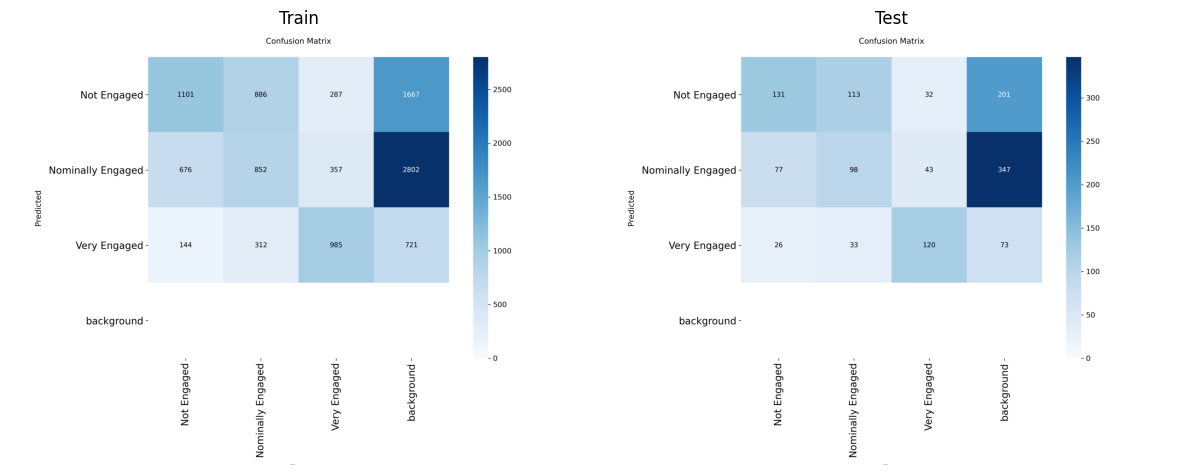

In [34]:
def find_cm(folder):
    p = os.path.join(run_dir, folder, "confusion_matrix.png")
    if not os.path.exists(p):
        p = p.replace(".png", "_normalized.png")
    assert os.path.exists(p), f"Confusion matrix tidak ditemukan di: {os.path.join(run_dir, folder)}"
    return p

train_cm = find_cm("eval_train")
test_cm  = find_cm("eval_test")

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(mpimg.imread(train_cm)); ax[0].set_title("Train"); ax[0].axis("off")
ax[1].imshow(mpimg.imread(test_cm));  ax[1].set_title("Test");  ax[1].axis("off")
plt.tight_layout(); plt.show()
plt.close(fig)

In [35]:
# Clear memory
gc.collect(); torch.cuda.empty_cache()

## 6.4 - Model Saving

In [36]:
finetune_dir = str(Path(res_ft.save_dir))
best_pt = os.path.join(finetune_dir, "weights", "best.pt")
run_dir = finetune_dir
print("Using:", best_pt)

Using: C:\Users\Ali\Documents\p2-final-project-ftds-030-hck-group01-abulearn-project\Final Project Group 1 HCK 030\p2-final-project-ftds-030-hck-group01-abulearn-project\runs\detect\finetune_unfreeze\weights\best.pt


In [37]:
confs = [0.30, 0.35, 0.40, 0.45]
rows = []
for c in confs:
    r = mdl.val(data=yaml, split="test",
                imgsz=160, conf=c, iou=0.60,
                device=0, amp=True, batch=4, workers=0, cache=False,
                plots=False, save=False, verbose=False,
                project=run_dir, name=f"eval_test_c{int(c*100)}", exist_ok=True)
    rows.append({"conf": c, **r.results_dict})
df_conf = pd.DataFrame(rows)[["conf","metrics/precision(B)","metrics/recall(B)","metrics/mAP50(B)","metrics/mAP50-95(B)"]]
display(df_conf)

# Choose best thresholds (conf, iou, imgsz)
BEST_CONF = float(df_conf.loc[df_conf["metrics/mAP50-95(B)"].idxmax(), "conf"])
BEST_IOU  = 0.60
BEST_IMGSZ = 160 
print("Chosen:", BEST_CONF, BEST_IOU, BEST_IMGSZ)

Ultralytics 8.3.196  Python-3.9.23 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
val: Fast image access  (ping: 0.40.1 ms, read: 12.51.3 MB/s, size: 6.1 KB)
val: Scanning C:\Users\Ali\Documents\p2-final-project-ftds-030-hck-group01-abulearn-project\Final Project Group 1 HCK 030\p2-final-project-ftds-030-hck-group01-abulearn-project\sample_data\sample_data_cleaned\test\labels.cache... 673 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 673/673  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 169/169 33.0it/s 5.1s0.1s
                   all        673        673      0.462      0.624      0.548      0.325
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 1.2ms postprocess per image
Ultralytics 8.3.196  Python-3.9.23 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 116.469.3 MB/s, size: 13.8 KB)
val: Scanning C:\Users

,conf,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B)
0,0.30,0.461766,0.623952,0.547835,0.325112
1,0.35,0.461766,0.623952,0.544332,0.327246
2,0.40,0.461766,0.623952,0.537142,0.327725
3,0.45,0.457597,0.631176,0.529514,0.327686


Chosen: 0.4 0.6 160


In [38]:
deploy_cfg = {"best_pt": best_pt, "conf": BEST_CONF, "iou": BEST_IOU, "imgsz": BEST_IMGSZ}
with open(os.path.join(run_dir, "deploy_config.json"), "w") as f:
    json.dump(deploy_cfg, f, indent=2)
print("Saved:", f.name)

Saved: C:\Users\Ali\Documents\p2-final-project-ftds-030-hck-group01-abulearn-project\Final Project Group 1 HCK 030\p2-final-project-ftds-030-hck-group01-abulearn-project\runs\detect\finetune_unfreeze\deploy_config.json
